In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

import json

2025-06-13 07:23:33.714390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749799413.959547      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749799414.026302      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def courbes(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [3]:
# paramètres 
input_shape = (299, 299, 3)
batch_size = 64
nb_classes = 7


In [4]:
learning_rate = 0.0001
# chargement du modèle
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape) ### InceptionResNetV2 ou InceptionV3
base_model.trainable = False

I0000 00:00:1749799488.493969      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749799488.494678      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
# ajout de couche personalisé

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(nb_classes, activation='softmax')  ### Pas retirer!!! Max 2 couches Dense sans compter celui ci
])

In [6]:
# compilation

model.compile(optimizer=Adam(learning_rate=learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [7]:
# preparation de données AVEC Data Augmentation 

datagen = ImageDataGenerator(
    rescale=1./255,#Normalise les pixels de l'image en les ramenant dans l'intervalle [0, 1]
    validation_split=0.2,#Réserve 20% des données pour la validation
    rotation_range=30,#Effectue une rotation aléatoire des images dans l’intervalle de + ou - 30 degrés.
    width_shift_range=0.15,#Décale horizontalement les images jusqu’à 10% de leur largeur
    height_shift_range=0.15,#Décale verticalement les images jusqu’à 10% de leur hauteur
    shear_range=0.15,#Applique une transformation de cisaillement (valeur en radians)
    brightness_range=[0.7, 1.3],#Varie la luminosité de l’image entre 70%-130%
    zoom_range=0.2,#Zoom avant/arrière aléatoire jusqu’à 20%
    horizontal_flip=True,#effet miroir
    fill_mode='nearest'#après transformation, remplissage des "trous" en copiant la valeur du pixel le plus proche
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
# preparation de données SANS Data Augmentation 

datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# chargement des données

train_gen = datagen.flow_from_directory(
    '/kaggle/input/bdallprj',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_gen = datagen.flow_from_directory(
    '/kaggle/input/bdallprj',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    '/kaggle/input/bdalltest',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14433 images belonging to 7 classes.
Found 3604 images belonging to 7 classes.
Found 344 images belonging to 7 classes.


In [9]:
print("Nombre d'images d'entraînement :", train_gen.samples)
print("Nombre d'images de validation  :", val_gen.samples)
print("Classes détectées :", train_gen.class_indices)

Nombre d'images d'entraînement : 14433
Nombre d'images de validation  : 3604
Classes détectées : {'Acne': 0, 'Carcinome_Basocellulaire': 1, 'Eczema': 2, 'Melanome': 3, 'Psoriasis': 4, 'Varicelle_Rougeole': 5, 'Variole': 6}


In [10]:
from sklearn.utils.class_weight import compute_class_weight


labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: 0.727286470143613, 1: 0.8464109781843772, 2: 1.5897125234056615, 3: 0.8165770862800565, 4: 1.2886607142857143, 5: 0.7863680941484145, 6: 1.8442371581906465}


In [12]:
# callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_checkpoint = ModelCheckpoint(
    filepath='IRV2_model1.keras',  ### Nom du fichier pour modèle avant fine-tuning
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [13]:
# entraînement
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop,reduce_lr,model_checkpoint],
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1749799624.634829      98 service.cc:148] XLA service 0x7fd7f80024b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749799624.635998      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749799624.636019      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749799629.473509      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749799648.821545      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4993 - loss: 1.5092
Epoch 1: val_loss improved from inf to 0.67806, saving model to IRV2_model1.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 643s 3s/step - accuracy: 0.4998 - loss: 1.5075 - val_accuracy: 0.7481 - val_loss: 0.6781 - learning_rate: 1.0000e-04
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7295 - loss: 0.7698
Epoch 2: val_loss improved from 0.67806 to 0.53396, saving model to IRV2_model1.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.7295 - loss: 0.7697 - val_accuracy: 0.7844 - val_loss: 0.5340 - learning_rate: 1.0000e-04
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7528 - loss: 0.6815
Epoch 3: val_loss did not improve from 0.53396
226/226 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.7528 - loss: 0.6814 - val_accuracy: 0.7825 - val_loss: 0.5752 - learning_rate: 1.0000e-04
Epoch 4/100
197/226 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7740 - loss: 0.6091
Epoch 4: val_l

In [14]:
# fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]: 
    layer.trainable = False

In [15]:
learning_rate = 0.00001 

In [16]:
model_checkpoint = ModelCheckpoint(
    filepath='IRV2_model2.keras', ### Nom du fichier pour modèle après fine-tuning
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [17]:
# compilation

model.compile(optimizer=Adam(learning_rate=learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
# re-entraîner
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop,reduce_lr,model_checkpoint]
)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7844 - loss: 0.5523
Epoch 1: val_loss improved from inf to 0.49011, saving model to IRV2_model2.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.7845 - loss: 0.5519 - val_accuracy: 0.8102 - val_loss: 0.4901 - learning_rate: 1.0000e-05
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8414 - loss: 0.3911
Epoch 2: val_loss did not improve from 0.49011
226/226 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.8414 - loss: 0.3911 - val_accuracy: 0.8147 - val_loss: 0.4962 - learning_rate: 1.0000e-05
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8451 - loss: 0.3781
Epoch 3: val_loss improved from 0.49011 to 0.45844, saving model to IRV2_model2.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.8451 - loss: 0.3781 - val_accuracy: 0.8271 - val_loss: 0.4584 - learning_rate: 1.0000e-05
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8519 - loss: 0.3493
Epoch 4

KeyboardInterrupt: 

In [19]:
model1 = load_model('IRV2_model1.keras')

In [20]:
# resultats

loss, test_accuracy = model1.evaluate(test_gen)
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Final Training Accuracy:   {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7429 - loss: 0.6696 
Testing Accuracy: 0.7093
Final Training Accuracy:   0.8446
Final Validation Accuracy: 0.8230


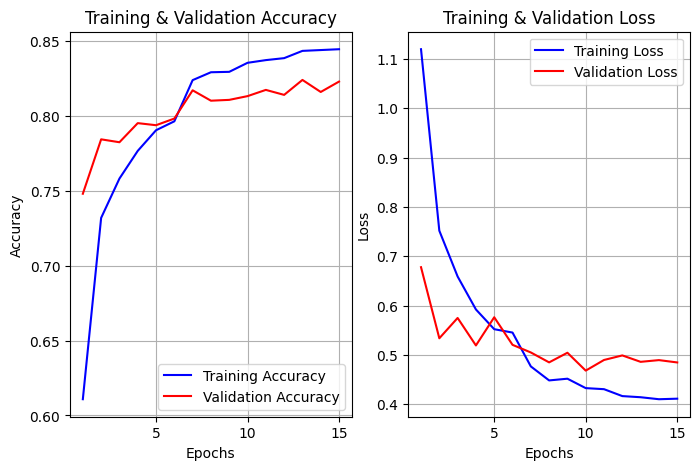

In [21]:
courbes(history)

In [22]:
model2 = load_model('IRV2_model2.keras')

In [25]:
# resultats

loss, test_accuracy = model2.evaluate(test_gen)
#final_train_acc = history_finetune.history['accuracy'][-1]
#final_val_acc = history_finetune.history['val_accuracy'][-1]

print(f"Testing Accuracy: {test_accuracy:.4f}")
#print(f"Final Training Accuracy:   {final_train_acc:.4f}")
#print(f"Final Validation Accuracy: {final_val_acc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.8010 - loss: 0.6340
Testing Accuracy: 0.7500


In [24]:
courbes(history_finetune)

NameError: name 'history_finetune' is not defined